# 한글 문서 토픽 모델링 (토픽트렌드로 시간에 따른 주제의 변화 알아내기)

JDK & JPype1 & KoNLPy 설치명령어

In [ ]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

환경변수 설정

In [ ]:
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

**데이터 확인**

In [ ]:
!pip install wget

In [4]:
import os
import wget
import ssl
import pandas as pd

In [5]:
data_dir = 'data'
url = 'https://s3.ap-northeast-2.amazonaws.com/data10902/petition/petition_sampled.csv'
ssl._create_default_https_context = ssl._create_unverified_context

In [6]:
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

wget.download(url, data_dir)

'data/petition_sampled.csv'

In [7]:
df = pd.read_csv("./data/petition_sampled.csv") #read data
df.head(5)

,article_id,start,end,answered,votes,category,title,content
0,58,2017-08-19,2017-11-17,0,21,일자리,국토교통부와 한국주택협회가 행한 부당한 행위와 권력남용에 대한 내용을 청원드립니다.,안녕하세요? 존경하고 지지하는 문재인 대통령님!\n저는 성남시 분당구 정자동 주택전...
1,63,2017-08-20,2017-09-04,0,1,보건복지,살려주세요..,안녕하십니까?\n저는 올해 63세된 홀로 사는 늙은 여자입니다...\n작년 중복날 ...
2,136,2017-08-20,2017-11-18,0,4,육아/교육,고등학교 교육 내용 수준을 낮춰주시고 실용적인 내용을 담아주세요!,저는 광주에 사는 중3 학생입니다. 고등학교 가기 직전의 학년이라 어느 때보다 고등...
3,141,2017-08-20,2017-08-27,0,0,기타,한국문화에 창조적요소를 심자,안녕하십니까\n저는 92년 한국을 알게된 종국동포 입니다.\n[저는 한 중소기업에...
4,148,2017-08-20,2017-11-18,0,7,외교/통일/국방,다문화정책 및 할랄 인증 제도,대한민국과 국민을 위해 밤낮 없이 수고하시는 대통령을 비롯한 위정자 분들께\n대한민...


**토크나이징 및 카운트 벡터 생성**

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Okt

twit = Okt()

def tokenizer(doc):
    return [token for token in twit.nouns(doc) if len(token) > 1]

cv = CountVectorizer(tokenizer=tokenizer,      # 명사만 사용
                      max_df=0.5, min_df = 5, 
                      max_features = 1000)      # 적당한 대상 단어 수를 선택

pet_cv = cv.fit_transform(df.content)   # content로 진행
print(pet_cv.shape)

(18077, 1000)


**LDA 토픽 모델링 실행**

In [9]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components = 15, \
                                n_jobs= -1, \
                                random_state=0)

pet_topics = lda.fit_transform(pet_cv)

In [10]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        # 위 slicing에서 맨 뒤 -1은 역순을 의미, 역순으로 했을 때 처음부터 n_top_words까지
        
print_top_words(lda, cv.get_feature_names(), 15)

Topic #0: 사람, 생각, 병원, 대통령, 피해자, 국민, 사건, 정말, 가족, 나라, 환자, 자신, 인간, 지금, 의사
Topic #1: 북한, 우리, 한국, 대통령, 정부, 국민, 대한민국, 미국, 일본, 문재인, 국가, 문제, 생각, 나라, 우리나라
Topic #2: 아이, 부모, 어린이집, 생각, 교사, 엄마, 우리, 유치원, 자녀, 가정, 동물, 출산, 아빠, 문제, 지원
Topic #3: 청소년, 불법, 폐지, 보호, 장애인, 조직, 사찰, 생각, 외국인, 이용, 노인, 사회, 나이, 범죄, 사람
Topic #4: 정부, 주택, 정책, 국민, 부동산, 서민, 아파트, 나라, 대통령, 세금, 지금, 사람, 투기, 집값, 임대
Topic #5: 일자리, 기업, 근무, 정부, 생각, 근로자, 지원, 임금, 최저임금, 시간, 정책, 회사, 직원, 대기업, 고용
Topic #6: 국민, 청원, 국회의원, 국회, 의원, 청와대, 세금, 반대, 생각, 건강, 동의, 제도, 대통령, 답변, 국가
Topic #7: 관리, 내용, 대한, 조사, 관련, 판결, 공사, 사실, 업무, 판사, 확인, 해당, 주민, 발생, 민원
Topic #8: 학생, 학교, 교육, 선수, 시험, 생각, 대학, 공부, 문제, 교사, 선생님, 시간, 제도, 위해, 고등학교
Topic #9: 보험, 연금, 국민연금, 공무원, 지급, 방송, 국민, 소득, 가입, 국가, 기초, 보험료, 공단, 군인, 수급
Topic #10: 여성, 공무원, 사회, 대한민국, 생각, 남성, 사람, 남자, 행정, 국민, 나라, 여자, 의무, 군대, 국가
Topic #11: 경찰, 범죄, 국민, 사건, 위해, 대한민국, 조직, 불법, 수사, 만행, 범죄자, 경찰서, 부정부패, 검찰, 살인마
Topic #12: 처벌, 피해자, 사건, 차량, 사고, 피해, 가해자, 범죄, 경우, 대한, 기사, 신고, 폭행, 행위, 택시
Topic #13: 민원, 화폐, 가상, 정부, 투자, 거래, 시장, 계획, 규제, 주식, 게임, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


**문서 별 토픽 확인**

In [12]:
trend_data = pd.DataFrame(pet_topics, columns=['Topic' + str(i) for i in range(0, 15)])
trend_data = pd.concat([trend_data, df.start.map(lambda x: x[:7])], axis=1)
trend_data.iloc[:5, :]

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,start
0,0.000307,0.000307,0.000307,0.058007,0.180857,0.000307,0.000307,0.757449,0.000307,0.000307,0.000307,0.000307,0.000307,0.000307,0.000307,2017-08
1,0.000813,0.000813,0.171417,0.000813,0.000813,0.057132,0.000813,0.000813,0.000813,0.140125,0.063464,0.000813,0.000813,0.000813,0.559732,2017-08
2,0.001449,0.001449,0.001449,0.001449,0.001449,0.001449,0.001449,0.001449,0.979710,0.001449,0.001449,0.001449,0.001449,0.001449,0.001449,2017-08
3,0.043334,0.642207,0.000227,0.000227,0.000227,0.253378,0.000227,0.000227,0.000227,0.000227,0.032685,0.000227,0.000227,0.000227,0.026129,2017-08
4,0.000447,0.392787,0.000447,0.000447,0.000447,0.024788,0.253386,0.021899,0.000447,0.000447,0.267475,0.000447,0.035637,0.000447,0.000447,2017-08


**월별 토픽트렌드 확인**

In [14]:
trend = trend_data.groupby(['start']).mean()
trend.iloc[:5, :]

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14
start,,,,,,,,,,,,,,,
2017-08,0.089730,0.094312,0.150915,0.012247,0.053707,0.127047,0.029538,0.088289,0.095113,0.040065,0.043216,0.015766,0.025389,0.024661,0.110004
2017-09,0.099067,0.055373,0.090419,0.282776,0.029143,0.043957,0.046928,0.039143,0.059452,0.022649,0.042948,0.023563,0.104047,0.019750,0.040786
2017-10,0.105827,0.079428,0.061719,0.037536,0.049183,0.090839,0.054206,0.065242,0.086764,0.036897,0.083816,0.053574,0.064864,0.032247,0.097858
2017-11,0.127303,0.058940,0.042874,0.028283,0.039929,0.055265,0.093545,0.053598,0.065447,0.029061,0.045919,0.045047,0.221295,0.045477,0.048018
2017-12,0.122659,0.074610,0.062640,0.036244,0.056667,0.103053,0.078535,0.067034,0.074629,0.035048,0.059587,0.027359,0.075098,0.050710,0.076128


**토픽 별 시간에 따른 변화 시각화**

In [15]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

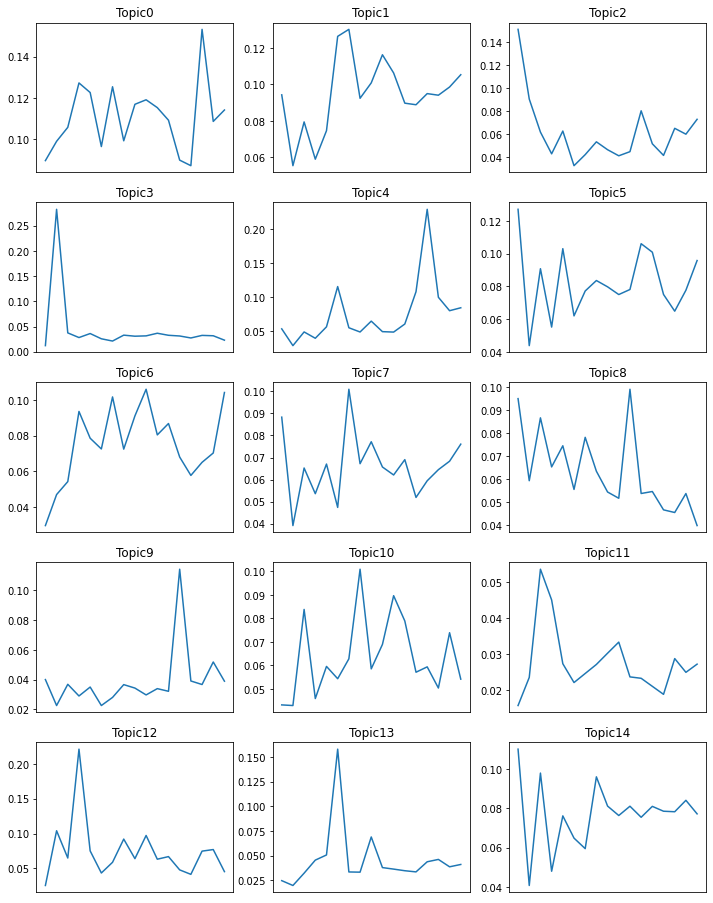

In [17]:
fig, axes = plt.subplots(5, 3, sharex='col', figsize=(12, 16)) 

for col, ax in zip(trend.columns.tolist(), axes.ravel()): 
    ax.set_title(col)
    ax.axes.xaxis.set_visible(False)
    ax.plot(trend[col])
    
plt.show()